In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from os import path
from PIL import Image

plt.style.use('ggplot')
pd.set_option('display.max_colwidth', -1)

# Data exploration

In [7]:
characters_df = pd.DataFrame.from_csv('./data/simpsons_characters.csv')
episodes_df = pd.DataFrame.from_csv('./data/simpsons_episodes.csv')
lines_df = pd.read_csv('./data/simpsons_script_lines.csv', 
                                 error_bad_lines=False,
                                 warn_bad_lines=False,
                                 low_memory=False)

In [8]:
characters_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6722 entries, 7 to 1868
Data columns (total 3 columns):
name               6722 non-null object
normalized_name    6722 non-null object
gender             323 non-null object
dtypes: object(3)
memory usage: 210.1+ KB


In [9]:
characters_df.head()

,name,normalized_name,gender
id,,,
7,Children,children,NaN
12,Mechanical Santa,mechanical santa,NaN
13,Tattoo Man,tattoo man,NaN
16,DOCTOR ZITSOFSKY,doctor zitsofsky,NaN
20,Students,students,NaN


In [10]:
episodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 10 to 548
Data columns (total 12 columns):
title                     600 non-null object
original_air_date         600 non-null object
production_code           600 non-null object
season                    600 non-null int64
number_in_season          600 non-null int64
number_in_series          600 non-null int64
us_viewers_in_millions    594 non-null float64
views                     596 non-null float64
imdb_rating               597 non-null float64
imdb_votes                597 non-null float64
image_url                 596 non-null object
video_url                 596 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 60.9+ KB


In [11]:
lines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158248 entries, 0 to 158247
Data columns (total 13 columns):
id                    158248 non-null int64
episode_id            158248 non-null int64
number                158248 non-null int64
raw_text              158248 non-null object
timestamp_in_ms       158248 non-null object
speaking_line         158248 non-null object
character_id          140727 non-null object
location_id           157841 non-null float64
raw_character_text    140726 non-null object
raw_location_text     157840 non-null object
spoken_words          132089 non-null object
normalized_text       132064 non-null object
word_count            132089 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 15.7+ MB


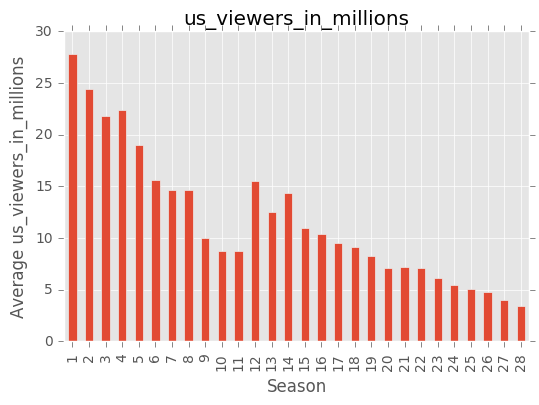

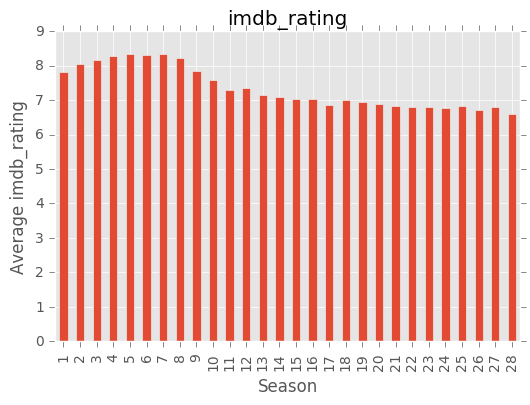

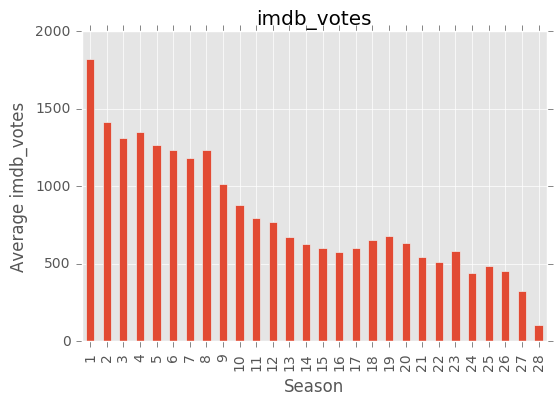

In [12]:
seasons_grouped = episodes_df.groupby(by='season')
by_season_vars = ['us_viewers_in_millions', 'imdb_rating', 'imdb_votes']
for var in by_season_vars:
    plt.figure()
    seasons_grouped.mean()[var].plot(kind='bar')
    plt.xlabel('Season')
    plt.ylabel('Average {}'.format(var))
    plt.title('{}'.format(var))
    plt.show()

In [13]:
# Check for unique characters

characters_lines = lines_df.join(other=characters_df, on='character_id')
characters_lines[characters_lines.character_id == '1'].raw_character_text.unique()

array(['Marge Simpson', 'Young Marge', "Marge's Thoughts", 'Teenage Marge'], dtype=object)

It looks like we have multiple raw character text names for each character. As a result, we're going to want to use the character ids for analysis.

In [14]:
character_names = ["Marge Simpson", "Homer Simpson", "Lisa Simpson", "Bart Simpson"]
char_ids= {}
for name in character_names:
    char_ids[name] = characters_lines[characters_lines.raw_character_text == name].character_id.unique()[0]

In [15]:
char_ids

{'Bart Simpson': '8',
 'Homer Simpson': '2',
 'Lisa Simpson': '9',
 'Marge Simpson': '1'}

In [16]:
# Function to prettify axes
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

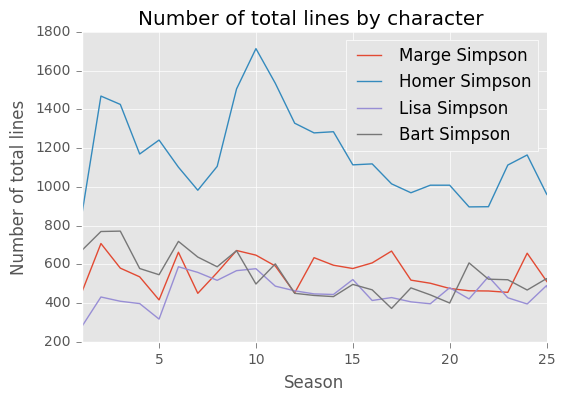

In [17]:
# Lines by family member by season
ax = plt.subplot(111)
lines_episodes = lines_df.join(other=episodes_df, on='episode_id')

for character in character_names:
    char_id = char_ids[character]
    season_group = lines_episodes[lines_episodes['character_id'] == char_id].groupby(by='season')
    plt.plot(season_group.count()['id'], label=character)

plt.legend()
plt.xlabel('Season')
plt.ylabel('Number of total lines')
plt.xlim([1,25])
plt.title('Number of total lines by character ')
simpleaxis(ax)
plt.savefig('bart_lisa_word_cloud.png', format='png', dpi=200)
plt.show()

Looks like there was a big drop-off for Homer around season 7. Let's zoom in on that.

There were 25 episodes in season 7


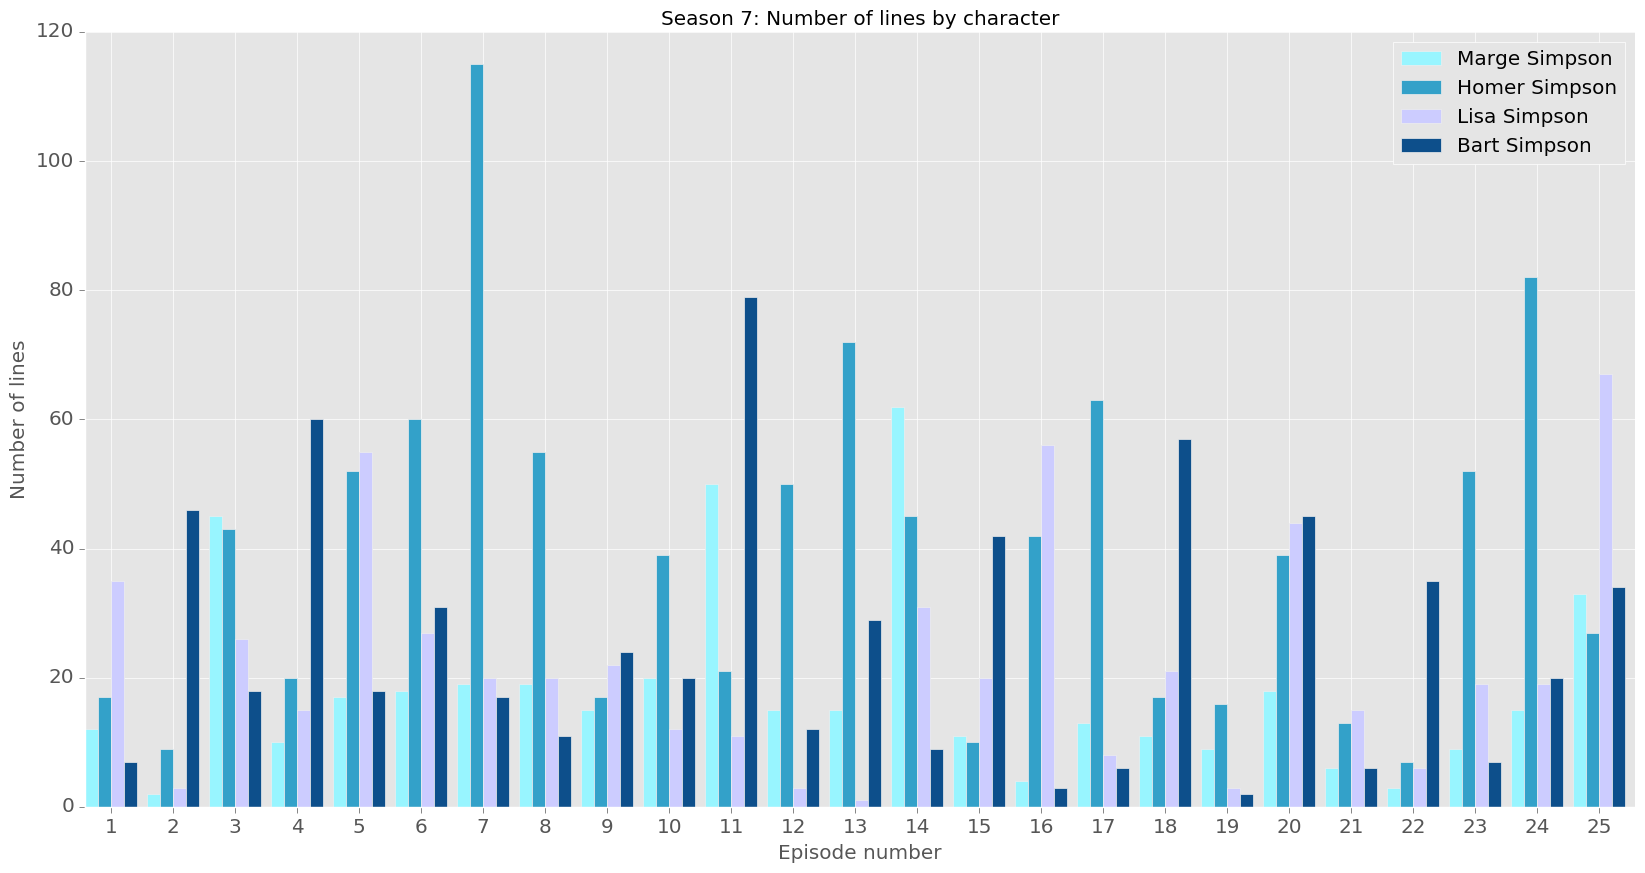

There were 23 episodes in season 10


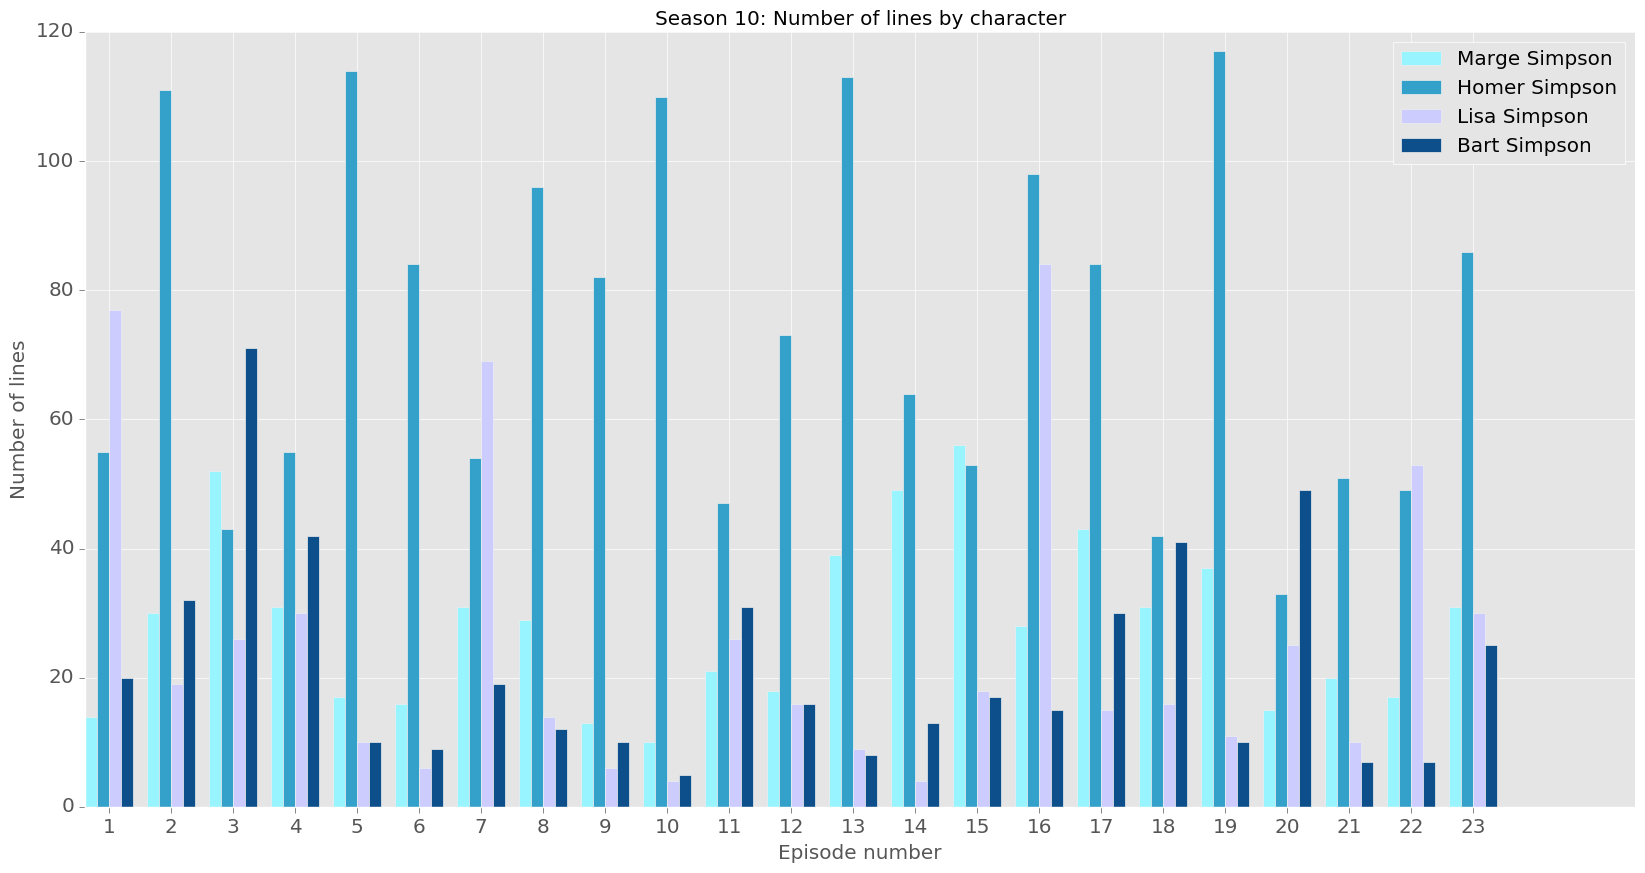

In [18]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def plot_num_lines(season):
    n_episodes = len(lines_episodes[lines_episodes.season == season].groupby(by='episode_id').count())
    print("There were {0} episodes in season {1}".format(n_episodes, season))
    ind = np.arange(n_episodes)  # the x locations for the groups
    width = n_episodes/120      # the width of the bars

    fig, ax = plt.subplots(figsize=(20, 10))
    colors = ['#98F5FF', '#33A1C9' , '#CCCCFF', '#0D4F8B']

    for idx, character in enumerate(character_names):
        char_id = char_ids[character]
        episode_group = lines_episodes[(lines_episodes['character_id'] == char_id) & (lines_episodes['season'] == season)].groupby(by='episode_id')
        ax.bar(ind + width * idx, episode_group.count()['id'], width, color = colors[idx], label=character)

    ax.set_xticks(ind + (width * 2))
    ax.set_xticklabels(range(1, n_episodes + 1))
    simpleaxis(ax)
    ax.set_xlabel("Episode number")
    ax.set_ylabel("Number of lines")
    ax.set_title("Season {}: Number of lines by character".format(season))
    plt.legend()
    plt.show()

plot_num_lines(7)
plot_num_lines(10)

It indeed looks like the other characters were much more prominent in season 7 than Homer--no one episode is to blame. This is possibly due to changes in the writers (e.g., season 7 was the first season run by Bill Oakley and Josh Weinstein, while Mike Scully took the helm starting at season 9).

# Predicting IMDB score based on each character's number of lines

In [19]:
df = lines_df[lines_df.character_id.notnull()]

# Build table with number of each character's line by episode  
char_group = df.groupby(by=['episode_id', 'character_id'])
multi = char_group.count()['id']
unstacked = multi.unstack()
pivoted = unstacked.fillna(0)

# Checksum
total_lines = sum(pivoted.sum(axis=1))
print("There are {0} lines in the pivoted table".format(int(total_lines)))

There are 140727 lines in the pivoted table


In [20]:
pivoted.head()

character_id,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,991,992,993,994,995,996,997,998,999,guess what i also play frankenstein
episode_id,,,,,,,,,,,,,,,,,,,,,
1,43.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,17.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hahaha. How did "guess what I also play frankenstein" get in there? I'm going to go ahead and remove any columns that are non-numeric.

In [21]:
def represent_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

cols = [c for c in pivoted.columns if represent_int(c)]
pivoted = pivoted[cols]

In [22]:
joined = pivoted.join(episodes_df)
X = pivoted[pivoted.isin(joined)]
y = joined.imdb_rating

# Only look at major characters — those that have 1000+ lines across the series
X_limited = X.drop([col for col, val in X.sum().iteritems() if val < 1000], axis=1, inplace=False)

# Make sure that we're training and testing on the same number of examples
assert(len(X_limited) == len(y))

It looks like we only have 16 characters with 1000+ lines across the whole series.

In [23]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import preprocessing

X_scaled = preprocessing.scale(X_limited, axis=1)

model = sm.OLS(y, X_scaled)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            imdb_rating   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     896.6
Date:                Thu, 18 May 2017   Prob (F-statistic):               0.00
Time:                        10:10:44   Log-Likelihood:                -1020.1
No. Observations:                 564   AIC:                             2070.
Df Residuals:                     549   BIC:                             2135.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4878      0.070      6.946      0.0

In [24]:
predictor_cols = X_limited.columns
predictor_labels = [characters_df.loc[int(x)]['name'] for x in predictor_cols]
predictor_labels

['Marge Simpson',
 'Nelson Muntz',
 'Ned Flanders',
 'Krusty the Clown',
 'Waylon Smithers',
 'C. Montgomery Burns',
 'Lenny Leonard',
 'Moe Szyslak',
 'Homer Simpson',
 'Apu Nahasapeemapetilon',
 'Milhouse Van Houten',
 'Seymour Skinner',
 'Grampa Simpson',
 'Chief Wiggum',
 'Bart Simpson',
 'Lisa Simpson']

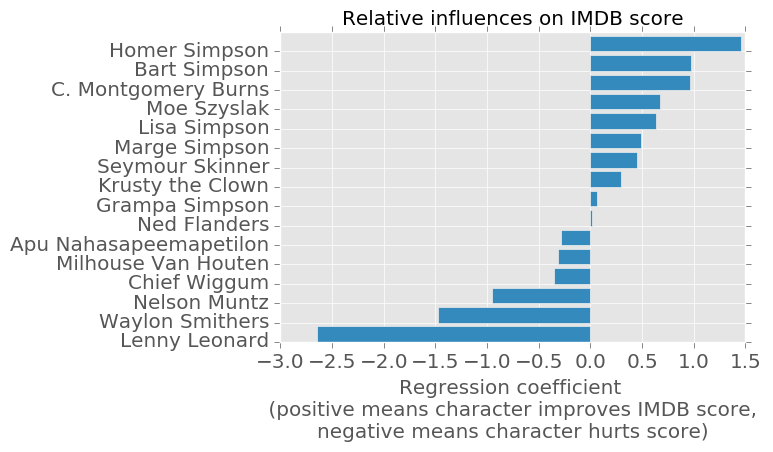

In [25]:
coeffs = results.params
sorted_labels = [y for (x, y) in sorted(zip(coeffs, predictor_labels))]
sorted_coeffs = sorted(coeffs)

# Plotting

x_vals = range(len(sorted_coeffs))
fig = plt.figure()

from pylab import *

val = sorted_coeffs    # the bar lengths
pos = arange(len(sorted_coeffs))   # the bar centers on the y axis

figure()
plt.barh(pos, sorted_coeffs)
yticks(pos, sorted_labels)
plt.xlabel('Regression coefficient \n (positive means character improves IMDB score, \nnegative means character hurts score)')
plt.title('Relative influences on IMDB score')
plt.yticks()
plt.show()

In [26]:
from statsmodels.tools import eval_measures

predictions = results.predict(X_scaled)
mean_abs_error = eval_measures.meanabs(y, predictions)
stdev = np.std(y)
print("Mean absolute error is {0} and standard deviation is {1}".format(mean_abs_error, stdev))

Mean absolute error is 1.0855882702460549 and standard deviation is 0.7305292244594646


So it doesn't actually look like we've really been able to predict anything that well. We can verify this with a few scatter plots:


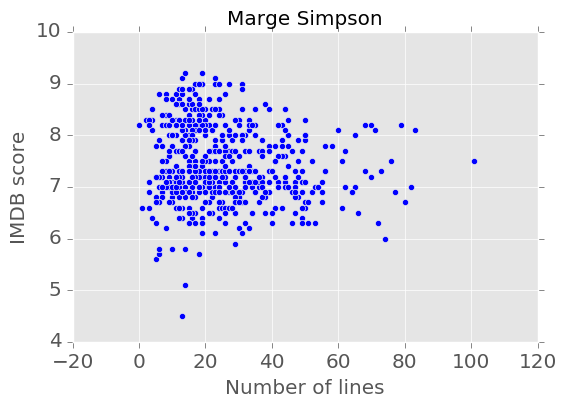

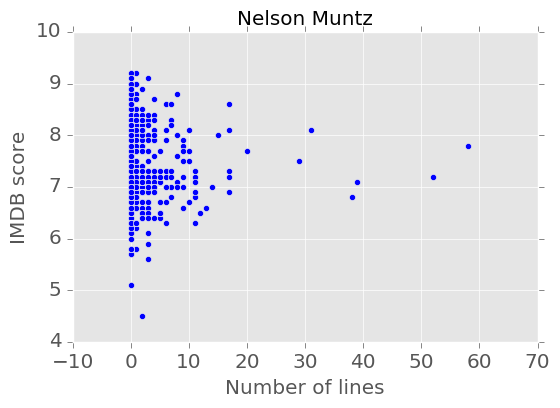

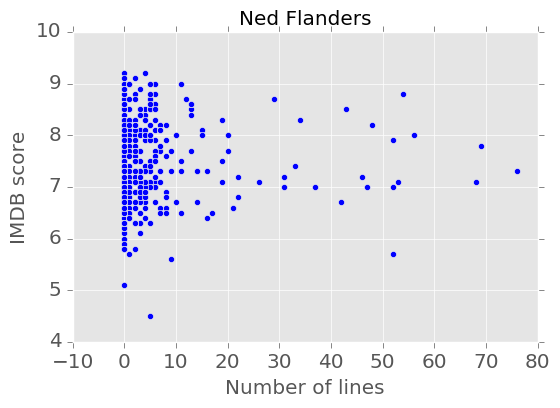

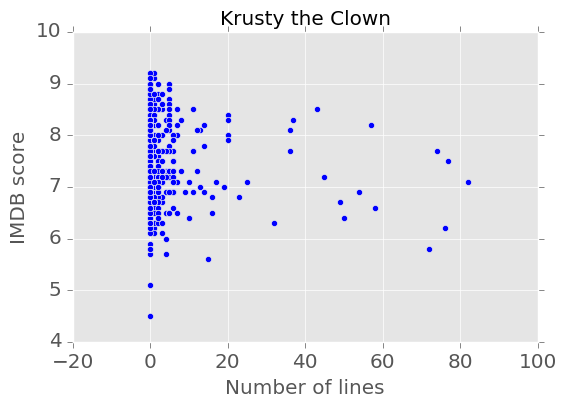

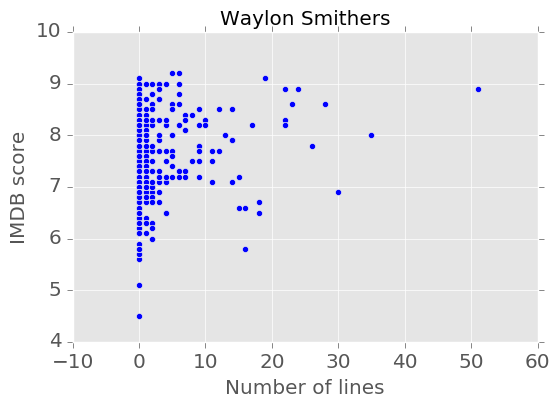

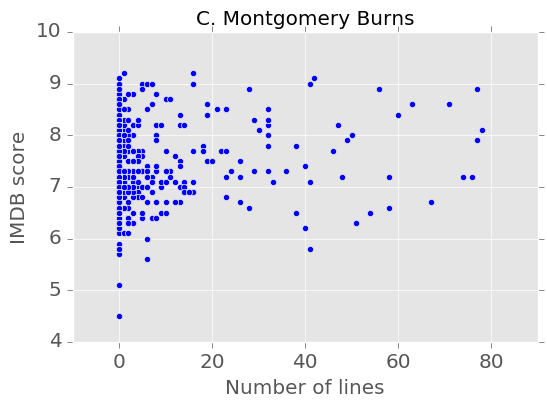

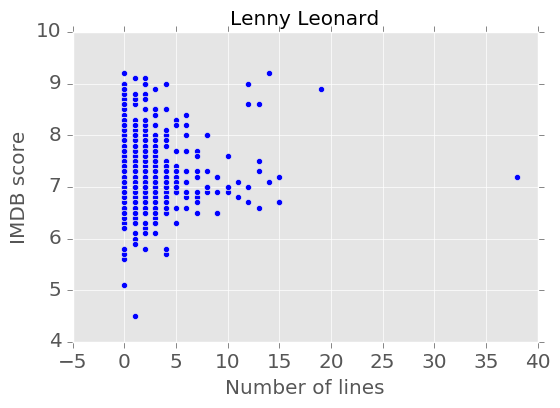

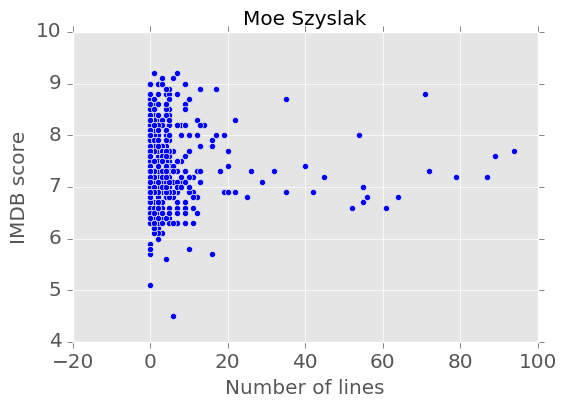

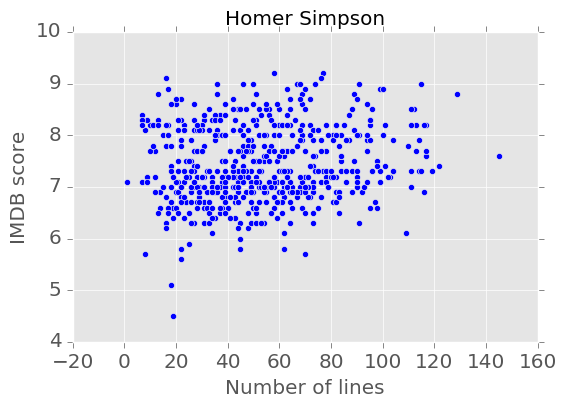

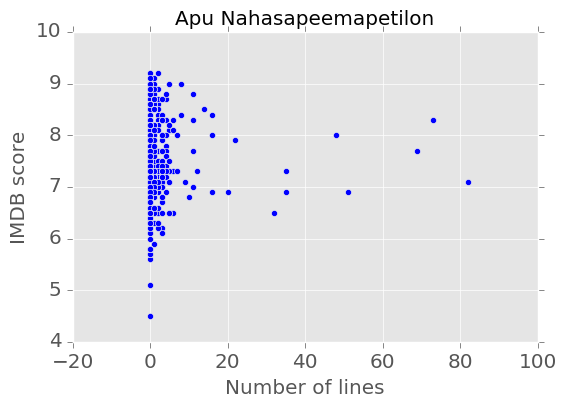

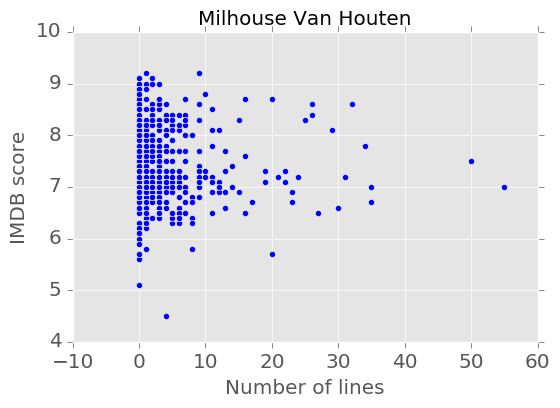

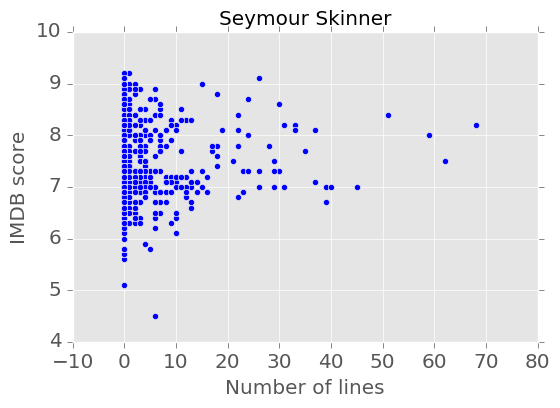

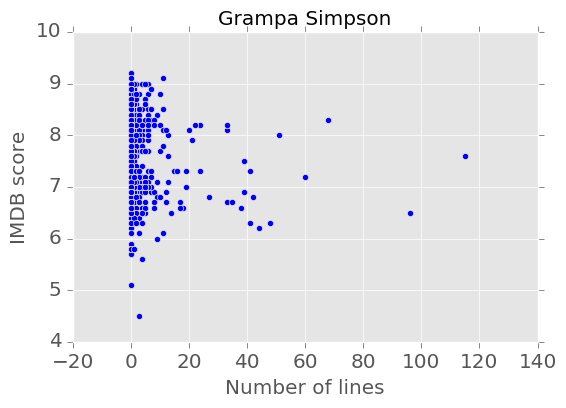

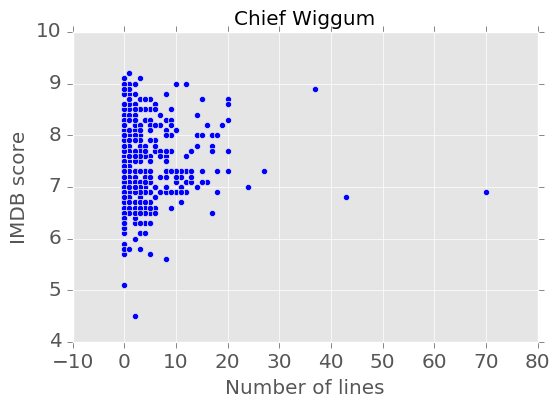

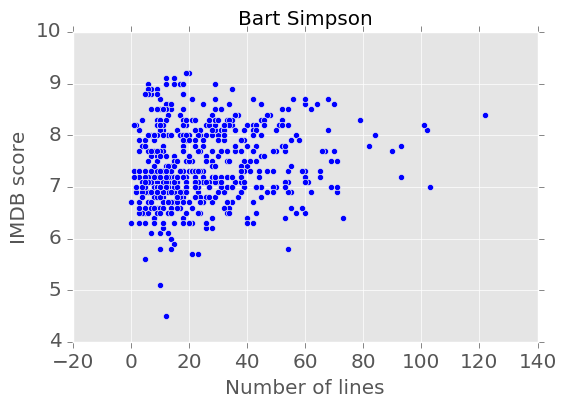

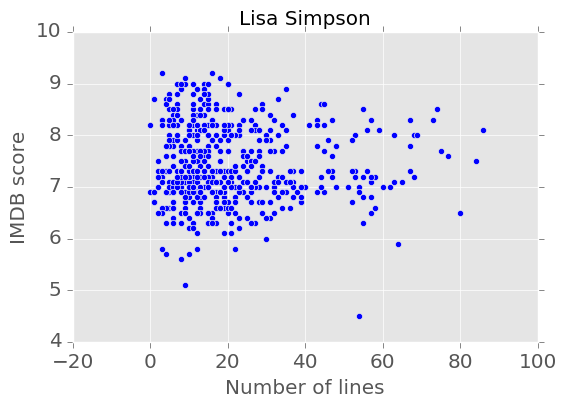

In [27]:
for idx, series in enumerate(X_limited):
    plt.figure()
    plt.scatter(X_limited[series], y)
    plt.title(predictor_labels[idx])
    plt.xlabel('Number of lines')
    plt.ylabel('IMDB score')
    plt.show()

# Predicting whether a line is Lisa or Bart's

In [60]:
temp = lines_df[lines_df['raw_character_text'].isin(['Bart Simpson', 'Lisa Simpson'])]
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25276 entries, 1 to 158241
Data columns (total 13 columns):
id                    25276 non-null int64
episode_id            25276 non-null int64
number                25276 non-null int64
raw_text              25276 non-null object
timestamp_in_ms       25276 non-null object
speaking_line         25276 non-null object
character_id          25276 non-null object
location_id           25245 non-null float64
raw_character_text    25276 non-null object
raw_location_text     25245 non-null object
spoken_words          23779 non-null object
normalized_text       23775 non-null object
word_count            23779 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 2.7+ MB


It doesn't look like that we have that many nulls – we can probably just drop the ~30 nulls for simplicity

In [61]:
lisa_and_bart = temp.dropna()

In [62]:
y = lisa_and_bart['raw_character_text'] == 'Lisa Simpson'
X = lisa_and_bart['normalized_text']

In [63]:
percent_bart = y.value_counts()[False]/sum(y.value_counts())
print("The base rate percent Bart is {0}".format(percent_bart))

The base rate percent Bart is 0.5473152242577385


In [64]:
import sklearn
import sklearn.linear_model as linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def train_model(X_train, y_train, X_test, y_test, classifier):

    model = classifier.fit(X_train, y_train)
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))

    print("Training accuracy is {0}".format(model.score(X_train, y_train)))
    print("Testing accuracy is {0}".format(model.score(X_test, y_test)))
    print("Precision is {0}".format(precision))
    print("Recall is {0}".format(recall))
    
    return model

In [65]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=8)

In [66]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [67]:
logistic = linear_model.LogisticRegression()
train_model(X_train, y_train, X_test, y_test, logistic)

Training accuracy is 0.7795325331648768
Testing accuracy is 0.6548747104653612
Precision is 0.6491978609625668
Recall is 0.5525716886663632


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Good stuff. We were able to do 11 points better in test accuracy than the base rate (54%) using a simple unigram model. We don't care too much about the tradeoff between precision/recall here since we don't have an a priori bias toward correctly identifying all Lisa lines vs. all Bart lines.

There are two things we can probably do to increase our accuracy:

* **Use a more sophisticated n-gram model.** This will allow us to capture multi-phrase words (e.g., capture 'ay caramba' as one feature instead of splitting it into two).
* **Tune the hyperparameters (e.g., level of cross-validation)**. We can do this with a simple grid search, but we probably want to do that after changing the number of n grams

In [68]:
bigram_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
trigram_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

print("Vectorizing bigrams")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=8)
bigram_vectorizer.fit(X_train)
X_train = bigram_vectorizer.transform(X_train)
X_test = bigram_vectorizer.transform(X_test)
logistic = linear_model.LogisticRegressionCV()
train_model(X_train, y_train, X_test, y_test, logistic)

print("\nVectorizing trigrams")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=8)
trigram_vectorizer.fit(X_train)
X_train = trigram_vectorizer.transform(X_train)
X_test = trigram_vectorizer.transform(X_test)
logistic = linear_model.LogisticRegressionCV()
simple_model = train_model(X_train, y_train, X_test, y_test, logistic)

Vectorizing bigrams
Training accuracy is 0.9337228890292694
Testing accuracy is 0.6479258791324489
Precision is 0.6395534290271132
Recall is 0.5475648611743287

Vectorizing trigrams
Training accuracy is 0.9558328069067172
Testing accuracy is 0.6460307433143819
Precision is 0.6327160493827161
Recall is 0.5598543468365954


It looks like the trigrams get us to pretty good training accuracy but our testing accuracy is still stuck at 65%. Let's try one last model — random forest.

In [37]:
from sklearn import ensemble

forest = ensemble.RandomForestClassifier()
train_model(X_train, y_train, X_test, y_test, forest)

Training accuracy is 0.9585702253105917
Testing accuracy is 0.5944409349336702
Precision is 0.586914688903143
Recall is 0.4164770141101502


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

 ¯\_(ツ)_/¯ okay no help there. Perhaps it's worth trying a unigram model with the random forest?

In [38]:
forest = ensemble.RandomForestClassifier()
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=8)
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)
train_model(X_train, y_train, X_test, y_test, forest)

Training accuracy is 0.9563065908612339
Testing accuracy is 0.5997052010949674
Precision is 0.5854503464203233
Recall is 0.46153846153846156


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Focusing in on long lines (10+ words)

In [39]:
num_words = [len(line.split()) for line in lisa_and_bart.normalized_text]
long_indicator = [wc >= 10 for wc in num_words]

In [40]:
lisa_and_bart[long_indicator].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8309 entries, 19 to 158241
Data columns (total 13 columns):
id                    8309 non-null int64
episode_id            8309 non-null int64
number                8309 non-null int64
raw_text              8309 non-null object
timestamp_in_ms       8309 non-null object
speaking_line         8309 non-null object
character_id          8309 non-null object
location_id           8309 non-null float64
raw_character_text    8309 non-null object
raw_location_text     8309 non-null object
spoken_words          8309 non-null object
normalized_text       8309 non-null object
word_count            8309 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 908.8+ KB


We've gone down to 8309 lines (long lines only), but that might actually increase our accuracy.

In [69]:
lab_long = lisa_and_bart[long_indicator]
y = lab_long['raw_character_text'] == 'Lisa Simpson'
X = lab_long['normalized_text']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=8)

trigram_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X_train)
X_train = trigram_vectorizer.transform(X_train)
X_test = trigram_vectorizer.transform(X_test)

logistic = linear_model.LogisticRegressionCV()
long_line_model = train_model(X_train, y_train, X_test, y_test, logistic)

Training accuracy is 1.0
Testing accuracy is 0.6859205776173285
Precision is 0.6710059171597633
Recall is 0.6991368680641183


In [39]:
X[:10]

19    well you got that right thanks for your vote girls                                                                                
21    well dont sweat it just so long as a couple of people did right milhouse                                                          
41    oh i mean were you just going to leave just like that                                                                             
43    you cant go youre the best teacher ill ever have                                                                                  
49    i i understand mr bergstrom im going to miss you                                                                                  
54    so i guess this is it it you dont mind ill just run alongside the train as it speeds you from my life                             
67    im glad im not crying because i would hate for you to think that what im about to say is based on emotion but you sir are a baboon
72    whoa somebody was bound to say it o

## Plotting

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt, mpld3
# plt.plot([3,1,4,1,5], 'ks-', mec='w', mew=5, ms=20)
# mpld3.show()

guessing = 0.5
base_rate = 1 - (sum(y_test)/len(y_test))
# simple_test_acc = simple_model.score(X_test, y_test)
simple_test_acc = 0.6460307433143819 ## using score from cell 68
long_test_acc = long_line_model.score(X_test, y_test)

y = [guessing, base_rate, simple_test_acc, long_test_acc]
x = ['Guessing', 'Base rate data skew', 'Logistic \n regression classifier', 'Logistic \n regression classifier \n (long words only)']
sns.barplot(x, y, palette="Greens_d")
plt.ylabel('Accuracy')
plt.title('Line prediction benchmark and model accuracy')
plt.ylim(ymax=1)
plt.savefig('line_prediction_model_accuracy.png', format='png', dpi=200)
mpld3.display()

#  Word clouds

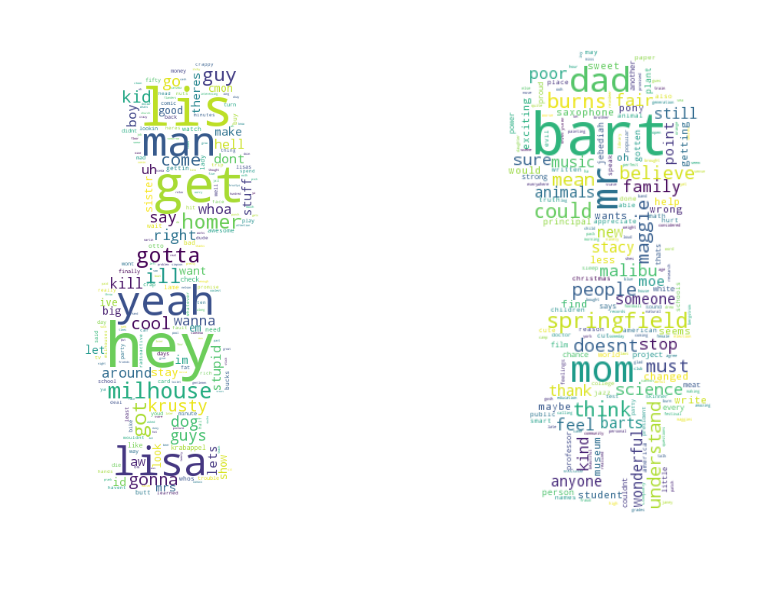

In [149]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
rcParams['figure.dpi'] = 1200

unigram_vec = TfidfVectorizer()
unigram_vec.fit(X.as_matrix())

lisa_transform = unigram_vec.transform(X[y])
bart_transform = unigram_vec.transform(X[~y])
lisa_agg_scores = np.sum(lisa_transform, axis=0)
bart_agg_scores = np.sum(bart_transform, axis=0)

stopWords = set(stopwords.words('english'))
additional_stopwords = ["you", "its", "to", "of", "the"]
for word in additional_stopwords:
    stopWords.add(word)

bart_mask = np.array(Image.open("./bart-simpson-mask.png"))
lisa_mask = np.array(Image.open("./lisa-simpson-mask.png"))

lisa_tups = {}
bart_tups = {}
for idx, name in enumerate(unigram_vec.get_feature_names()):
    lisa_tups[name] = int(lisa_agg_scores[:, idx]) - int(bart_agg_scores[:, idx])
    bart_tups[name] = -lisa_tups[name]
    if name in stopWords:
        lisa_tups[name] = 0
        bart_tups[name] = 0

# Bart cloud
bart_wc = WordCloud(random_state=5, max_words=4000, mask=bart_mask, background_color="white", width=1200, height=1200)
bart_wc.fit_words(bart_tups)

# Lisa cloud
lisa_wc = WordCloud(random_state=5, max_words=4000, mask=lisa_mask, background_color="white", width=1200, height=1200)
lisa_wc.fit_words(lisa_tups)


f, axarr = plt.subplots(1, 2)
axarr[0].imshow(bart_wc, interpolation='bilinear')
axarr[0].axis('off')
axarr[1].imshow(lisa_wc, interpolation='bilinear')
axarr[1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('bart_lisa_word_cloud.png', format='png', dpi=200)
plt.show()